In [2]:
import os, nltk

cuda_device = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda_device)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.express as px
import pandas as pd
from tqdm import tqdm
from evaluate import load
from datasets import load_dataset

In [3]:
dataset = load_dataset("DReAMy-lib/DreamBank-dreams-en")

dataset_df = pd.DataFrame(dataset["train"])

dataset_df["No.Words"] = [
    len(nltk.word_tokenize(report)) for report in tqdm(dataset_df["dreams"])
]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████| 22415/22415 [00:24<00:00, 925.51it/s]


In [4]:
# Since the perplexity metric from hugging face is still not 100% hacakble 
# (i.e., is not easy to set truncation), we'll have to select those reports with a 
# "limited" ammount of words
dataset_df_test = dataset_df[dataset_df["No.Words"] <= 700]
dream_list = dataset_df_test["dreams"].tolist()

In [5]:
# Check the space (https://huggingface.co/spaces/evaluate-metric/perplexity) for more info
perplexity = load("perplexity", module_type="metric")

In [7]:
p = perplexity.compute(predictions=dream_list, model_id='gpt2', add_start_token=False)

Using pad_token, but it is not set yet.


  0%|          | 0/1351 [00:00<?, ?it/s]

In [16]:
# lets now update (and save) our test DataFrame
dataset_df_test["GPT2_perplexities"] = list(p["perplexities"])

dataset_df_test.to_csv("DreamBank_en_pptx_GPT2.csv")

/tmp/ipykernel_77135/1827614491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df_test["GPT2_perplexities"] = list(p["perplexities"])


In [20]:
dataset_df_test[["GPT2_perplexities"]].describe()

,GPT2_perplexities
count,21607.000000
mean,49.553180
std,401.778635
min,4.423346
25%,25.185008
50%,32.667839
75%,45.742916
max,56966.582031


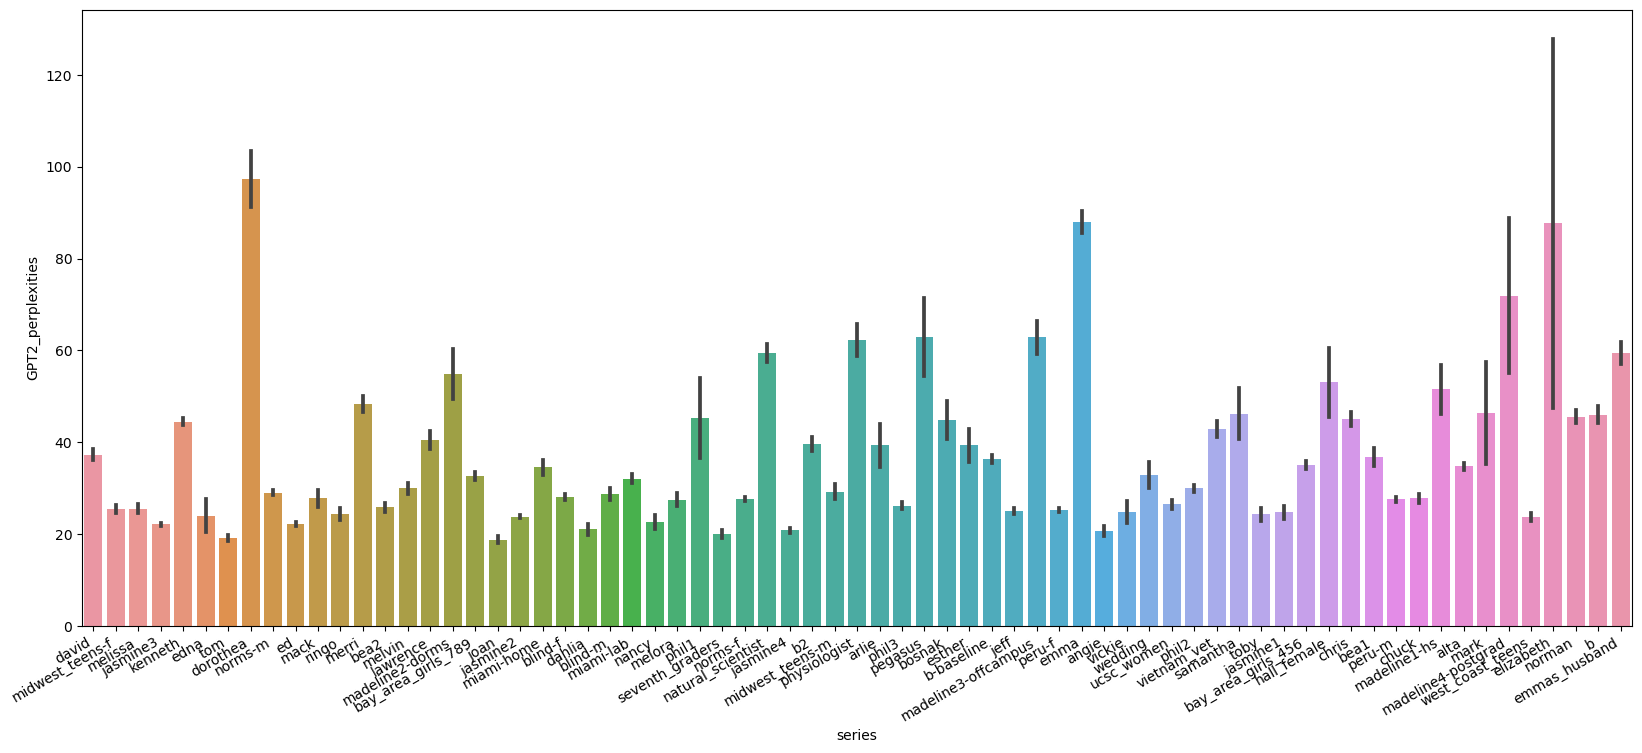

In [42]:
plt.figure(figsize=(20,8))
g = sns.barplot(
    data=dataset_df_test,
    y="GPT2_perplexities",
    x="series",
    errorbar=("se", 1)
)
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')
print()

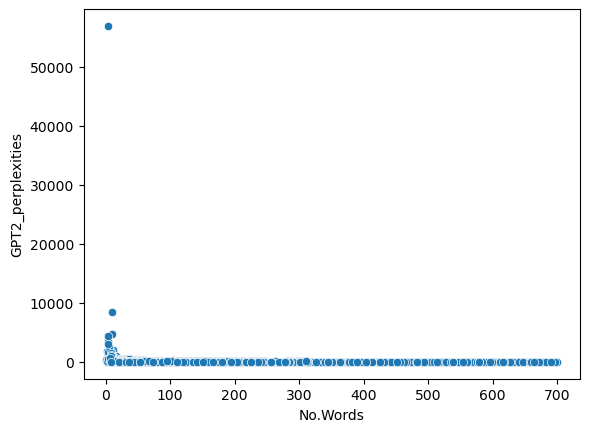

In [50]:
# plt.figure(figsize=(20,8))
g = sns.scatterplot(
    data=dataset_df_test,
    y="GPT2_perplexities",
    x="No.Words",
)

In [78]:
data_of_interest = dataset_df_test[dataset_df_test["GPT2_perplexities"] <= 200]
data_of_interest = data_of_interest[data_of_interest["No.Words"] >= 10]

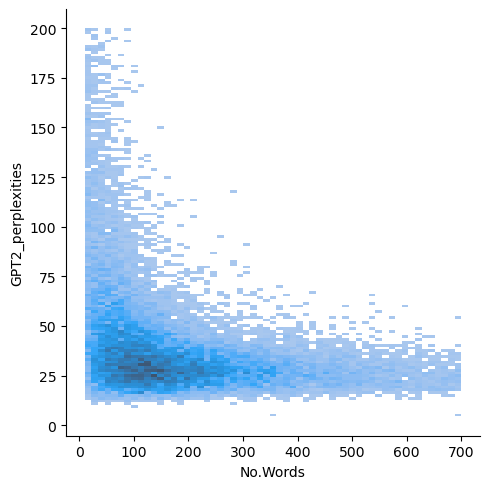

In [79]:
g = sns.displot(
    data=data_of_interest,
    y="GPT2_perplexities",
    x="No.Words",
)

In [80]:
fig = px.scatter(
    dataset_df_test, 
    y="GPT2_perplexities",
    x="No.Words",
    color="series",
)
fig.show()

In [81]:
stats.spearmanr(
    dataset_df_test["GPT2_perplexities"], 
    dataset_df_test["No.Words"]
)

SpearmanrResult(correlation=-0.4520691845428805, pvalue=0.0)

In [82]:
data_of_interest = dataset_df_test[dataset_df_test["GPT2_perplexities"] <= 200]
data_of_interest = data_of_interest[data_of_interest["No.Words"] >= 20]
stats.spearmanr(
    data_of_interest["GPT2_perplexities"], 
    data_of_interest["No.Words"]
)

SpearmanrResult(correlation=-0.396944589727396, pvalue=0.0)

In [110]:
pptx_nwrd_corr = []
for i in tqdm(range(0, max(dataset_df_test["No.Words"]), 10)):
    for j in range(0, 200, 2):
        data_of_interest = dataset_df_test[dataset_df_test["GPT2_perplexities"] <= j]
        data_of_interest = data_of_interest[data_of_interest["No.Words"] >= i]
        r, p_v = stats.spearmanr(
            data_of_interest["GPT2_perplexities"], 
            data_of_interest["No.Words"]
        )
        pptx_nwrd_corr.append([i, j, r])

100%|████████████████████████████████████████████████████████████████████████████| 70/70 [00:20<00:00,  3.39it/s]


In [111]:
pptx_nwrd_corr_df = pd.DataFrame(
    pptx_nwrd_corr, 
    columns=["No.Words", "GPT2_perplexities", "\u03C1"]
)

In [112]:
fig = px.scatter_3d(
    pptx_nwrd_corr_df[pptx_nwrd_corr_df["GPT2_perplexities"] <= 100], 
    x="No.Words", 
    y="GPT2_perplexities", 
    z="\u03C1",
)
fig.update_traces(marker_size = 2)
fig.show()

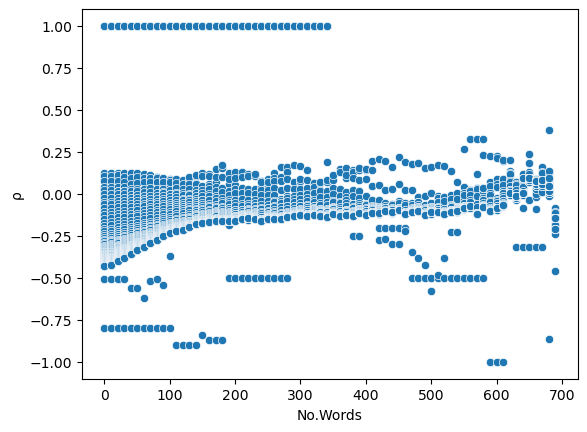

In [114]:
g = sns.scatterplot(
    pptx_nwrd_corr_df, 
    x="No.Words",
    y="\u03C1",
)

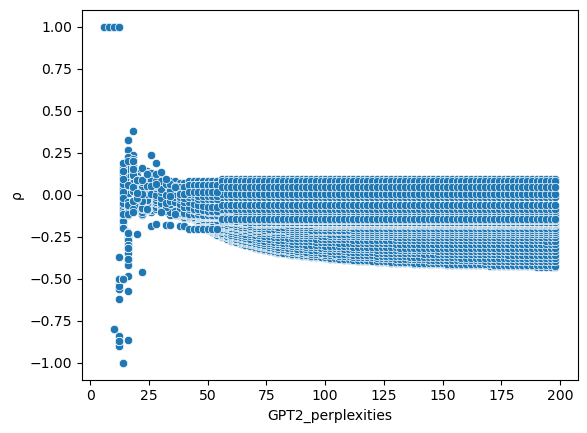

In [117]:
g = sns.scatterplot(
    pptx_nwrd_corr_df, 
    x="GPT2_perplexities",
    y="\u03C1",
)